# 0. Set Up

In [1]:
# Librerias
!git clone https://github.com/domingomery/balu3
!pip install ./balu3

Cloning into 'balu3'...
remote: Enumerating objects: 270, done.
remote: Counting objects: 100% (270/270), done.
remote: Compressing objects: 100% (191/191), done.
remote: Total 270 (delta 157), reused 180 (delta 75), pack-reused 0
Receiving objects: 100% (270/270), 71.11 KiB | 2.73 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Processing ./balu3
  Preparing metadata (setup.py) ... done
  Created wheel for balu3: filename=balu3-1.0-py3-none-any.whl size=43701 sha256=33fb7b3011bc0c55836962907732b19dd03102de690fe872b7c4fb1af084e9f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-7bhcoa1a/wheels/9e/f6/a9/3d39da83a3504331129d706f5b04ceb3dbf0ec0f313cdb8fcf
Successfully built balu3


In [95]:
# Numpy & Maplotlib
import numpy             as np
import matplotlib.pyplot as plt
import cv2


# Balu
from   balu3.ft.norm     import minmax
from   balu3.fx.chr      import lbp, haralick, gabor, hog, basicint, contrast, clp
from   balu3.fs.sel      import jfisher
from   balu3.fs.sel      import sfs, exsearch, clean
from   balu3.fx.geo      import basicgeo,fitellipse,hugeo,flusser,gupta
from   tqdm.auto         import tqdm
from   balu3.im.proc import im_grad,fspecial,gradlog
from   balu3.ft.trans  import pca

# Sklearn
from sklearn.metrics   import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid # KNN y DMin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA

from sklearn.naive_bayes import GaussianNB  # Naive Bayer
from sklearn.base import BaseEstimator, ClassifierMixin # Bayes KDE
from sklearn.neighbors import KernelDensity

from sklearn.tree import DecisionTreeClassifier # Decision Tree
from sklearn.ensemble import RandomForestClassifier # Random Forest
from sklearn.linear_model import LogisticRegression # Regresion logistica
from sklearn.neural_network import MLPClassifier # NN
from sklearn.svm import SVC # SVM

from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import SelectFromModel


from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

from   sklearn.model_selection import train_test_split

from   sklearn.cross_decomposition import PLSRegression
from   sklearn.decomposition       import FastICA
from   mlxtend.feature_selection   import SequentialFeatureSelector as mlxsfs


# 1. Image Loading

In [3]:
!wget https://www.dropbox.com/scl/fi/1egkpx414yen4affvczw9/jaffec.zip?rlkey=txhzx69hg0wh2xklmg3oc1u6t
!mv jaffec.zip?rlkey=txhzx69hg0wh2xklmg3oc1u6t jaffec.zip
!unzip -qq jaffec.zip

--2024-06-19 15:37:57--  https://www.dropbox.com/scl/fi/1egkpx414yen4affvczw9/jaffec.zip?rlkey=txhzx69hg0wh2xklmg3oc1u6t
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601f:18::a27d:912
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucaa1e9282e4449702c37a8723f2.dl.dropboxusercontent.com/cd/0/inline/CVL2Ex8EQKlCJvQPLMU_sWtdXVHOK-ZuBTGm_p6efcuc0do682s7sFz-7mye0vjfXTNCjQdqFgB_7MaOrYUQRfYbZZ8xaDBhwG3mLXXPc6g3hTvMwy2PfA2DLNsP9TqN8bo/file# [following]
--2024-06-19 15:37:58--  https://ucaa1e9282e4449702c37a8723f2.dl.dropboxusercontent.com/cd/0/inline/CVL2Ex8EQKlCJvQPLMU_sWtdXVHOK-ZuBTGm_p6efcuc0do682s7sFz-7mye0vjfXTNCjQdqFgB_7MaOrYUQRfYbZZ8xaDBhwG3mLXXPc6g3hTvMwy2PfA2DLNsP9TqN8bo/file
Resolving ucaa1e9282e4449702c37a8723f2.dl.dropboxusercontent.com (ucaa1e9282e4449702c37a8723f2.dl.dropboxusercontent.com)... 162.125.5.15, 2620:100:601d:15::a27d:50f
Connecting to ucaa1e928

In [4]:
def num2fixstr(x: int, d: int) -> str:
    """
    Transforma en un string un numero x en una cantidad de x digitos
    """
    string = '%0*d' % (d, x)
    return string

def get_image_path(num_class: int, num_img: int, sep='_') -> str:
    """
    Retorna la ruta de la imagen a cargar dada una clase num_class y un
    identificador de imagen num_img
    """

    FPATH = 'jaffec'
    PREFIX = 'face'
    img_class = num2fixstr(num_class, 3)
    img_num = num2fixstr(num_img, 5)
    img_path = f'{FPATH}/{PREFIX}_{img_class}_{img_num}.png'

    return img_path

def imageload(num_class: int, num_img: int, echo='off') -> str:
    """
    Carga la imagen
    """
    path = get_image_path(num_class, num_img)
    if echo == 'on':
        print(f'loading image {path} ...')
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)

    return img

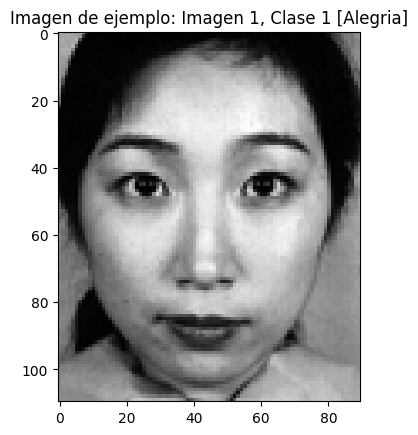

In [5]:
test_img = imageload(1,1)
plt.title('Imagen de ejemplo: Imagen 1, Clase 1 [Alegria]')
plt.imshow(test_img, cmap='gray')
plt.show()

# 2. Image Preprocessing [TODO]

👉🏻 Aplicamos el clasificador Haar Cascade preentrenado para detectar el perfil frontal de la cara de una persona.
👉🏻 Luego, aplicamos este clasificador sobre la imagen con los siguientes parametros:
* `scaleFactor = 1.1`: reducimos la imagen en un 10% de su tamaño original
* `minNeighbors = 5`: especifica el numero de rectangulos vecinos que necesita el clasificador para que un objeto se considere valido
* `minSize= (40,40)`: tamaño minimo del objeto a aser detectado.

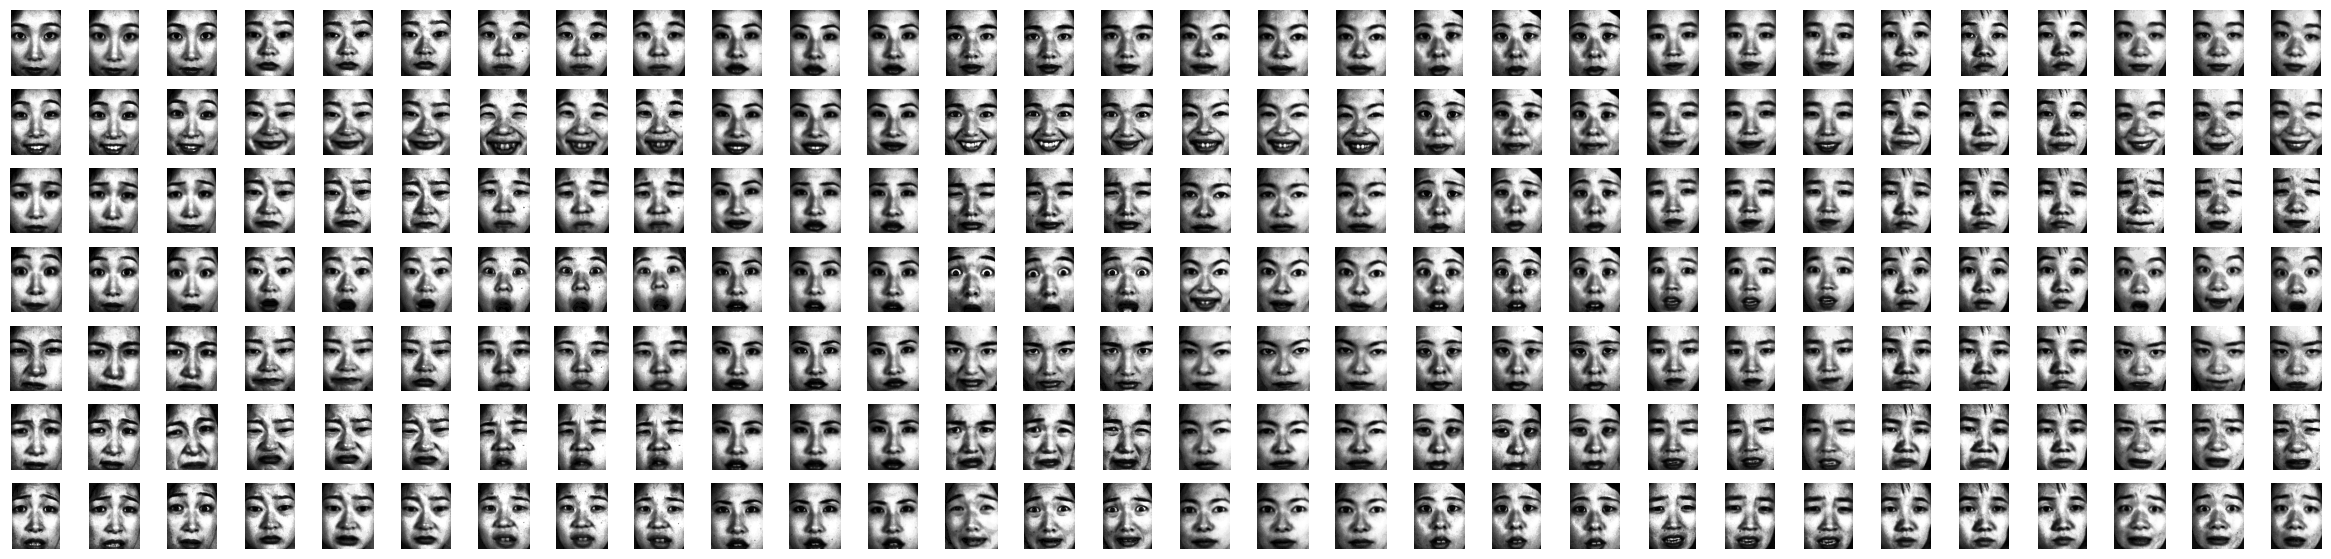

In [7]:
def eyes_detection(face, show=False):
    """
    input: imagen recortada que solo contiene la cara de la persona.
    output: bounding box de cada ojo (x, y, width, height)
    """

    eyes_classifier = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_eye.xml"
    )
    eyes = eyes_classifier.detectMultiScale(
        face, scaleFactor=1.35, minNeighbors=1
    )
    eye_1, eye_2 = None, None
    index = 0
    face2show = np.copy(face) # Realizamos una copia para no modificar la img original
    for (ex , ey,  ew,  eh) in eyes:
        if index == 0:
            eye_1 = (ex, ey, ew, eh) # bounding box ojo 1
        elif index == 1:
            eye_2 = (ex, ey, ew, eh) # bounding box ojo 2
        index = index + 1

    # En el caso que no lo detecte, lo hacemos manualmente, realizando copia del
    #bounding box de ey2 pero trasladado simetricamente
    height, width = face.shape
    # cond1-3: casos en donde no se detecta alguno de los ojos (o ambos)
    cond1 = (eye_1 is None and eye_2 is None)
    cond2 = (eye_1 is not None and eye_2 is None)
    cond3 = (eye_1 is None and eye_2 is not None)
    # cond4-5: casos en donde se detectan cosas, pero una de ellas no es un ojo
    cond4 = False
    cond5 = False
    if (eye_1 and eye_2) is not None:
        # Si ambos bounding box solapan, entonces manipulo la posicion manualmente
        cond4 = eye_1[0] <= eye_2[0] and eye_2[0] <= eye_1[0] + eye_1[2]
        cond5 = eye_2[0] <= eye_1[0] and eye_1[0] <= eye_2[0] + eye_2[2]
    # Si se cumple algunos de los 5 casos, entonces manipulamos la ubicacion
    # de los ojos manualmente ...
    if cond1 or cond2 or cond3 or cond4 or cond5:
        eye_1 = (10, 20, 20, 20) # aproximadamente ...
        eye_2 = (width // 2, 20, 20, 20)

    # Verificamos la posicion dentro del eje x para cada bounding box, con el
    # fin de identificar que ojo es cada uno (izquierdo o derecho).
    if eye_1[0] < eye_2[0]:
        left_eye = eye_1
        right_eye = eye_2
    else:
        left_eye = eye_2
        right_eye = eye_1

    if show:
        ex1, ey1, ew1, eh1 = eye_1
        ex2, ey2, ew2, eh2 = eye_2
        cv2.rectangle(face2show, (ex1, ey1), (ex1 + ew1, ey1 + eh1), (255,255,255), 1)
        cv2.rectangle(face2show, (ex2, ey2), (ex2 + ew2, ey2 + eh2), (255,255,255), 1)
        plt.imshow(face2show, cmap='gray')
        plt.title('Deteccion de los ojos')
        plt.show()

    return left_eye, right_eye

def get_eyes_position(left_eye, right_eye):
    """
    input: bounding box del ojo izquierdo y derecho.
    output: posicion de cada ojo (el punto central del bounding box de cada ojo)
    """
    # Calculamos el punto central del ojo izquierdo
    left_eye_center = (
        int(left_eye[0] + (left_eye[2] / 2)), int(left_eye[1] + (left_eye[3] / 2))
        )
    left_eye_x, left_eye_y = left_eye_center[0], left_eye_center[1]
    # Calculamos el punto central del ojo derecho (i.e. pupila)
    right_eye_center = (
        int(right_eye[0] + (right_eye[2] / 2)), int(right_eye[1] + (right_eye[3] / 2))
        )
    right_eye_x, right_eye_y = right_eye_center[0], right_eye_center[1]

    return (left_eye_x, left_eye_y), (right_eye_x, right_eye_y)


def face_align(img, left_eye, right_eye, show=False):
    """
    Funcion que recibe la imagen original y las zonas donde se encuentra cada ojo.
    Retorna la imagen rotada segun la diferencia de alturas entre los ojos.
    """
    # Calculamos el punto central del ojo izquierdo y derecho (pupilas)
    left_eye_pos, right_eye_pos = get_eyes_position(left_eye, right_eye)
    left_eye_x, left_eye_y = left_eye_pos
    right_eye_x, right_eye_y = right_eye_pos
    # Ahora, utilizando la ubicacion de cada pupila de los ojos, buscamos
    # la recta "A" que une ambos puntos para posteriormente calcular el angulo
    # de rotacion
    if left_eye_y > right_eye_y:
        line_between_eyes = (right_eye_x, left_eye_y)
        rot_direction = -1 # el -1 indica que la imagen sera rotada en la direccion horaria
    else:
        line_between_eyes = (left_eye_x, right_eye_y)
        rot_direction = 1 # el 1 indica que la imagen sera rotada en la direccion antihoraria

    # Calculamos el angulo de rotacion entre la linea que separa ambos ojos
    delta_x = right_eye_x - left_eye_x    # cateto adyacente
    delta_y = right_eye_y - left_eye_y    # cateto opuesto
    angle = np.arctan(delta_y / delta_x)
    angle = (angle * 180) / np.pi         # Obtenemos el angulo en grados

    height, width = img.shape[:2] # Alto y ancho de la imagen
    center_img = (width // 2, height // 2) # Centro de la imagen
    # definimos la matriz de rotacion
    rot_matrix = cv2.getRotationMatrix2D(center_img, (angle), 1.0)
    # aplicamos la rotacion sobre la imagen
    face_rotated = cv2.warpAffine(img, rot_matrix, (width, height))

    if show:
        plt.title('Imagen rotada segun la posicion de los ojos')
        plt.imshow(face_rotated, cmap='gray')
        plt.show()

    return face_rotated

def face_detection(img, show=False):
    """
    Funcion que retorna la zona de la imagen en donde se encuentra la cara de una
    persona
    """
    face_classifier = cv2.CascadeClassifier(
        cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
    )
    face = face_classifier.detectMultiScale(
        img, scaleFactor=1.005, minNeighbors=5, minSize=(30, 50)
    )
    x, y, width, height = face[0]
    face_cropped = img[y:(y + height), x:(x + width)]

    if show:
        # Mostramos el resultado de la deteccion de la cara
        img2show = np.copy(img)
        plt.title('Deteccion de la cara')
        cv2.rectangle(img2show, (x, y), (x + width, y + height), (255, 255, 255), 1)
        plt.imshow(img2show, cmap='gray')
        plt.show()

    return face_cropped, (x, y, width, height)


def reshape(img, left_eye, right_eye):
    # Restaremos 8 pixeles de diferencia hacia la izquierda desde el ojo izquierdo
    # y hacia la derecha del ojo derecho
    left_eye_pos, right_eye_pos = get_eyes_position(left_eye, right_eye)
    left_eye_pos_x, left_eye_pos_y = left_eye_pos
    right_eye_pos_x, right_eye_pos_y = right_eye_pos
    height, width = img.shape

    center = ((left_eye_pos_x + right_eye_pos_x) / 2, (left_eye_pos_y + right_eye_pos_y) / 2)
    # Determinamos nuestra region de interes segun el lugar donde se
    # ubican los ojos ...
    roi_x_start = int(width / 2 - center[0] * 0.8)
    roi_x_end = int(width / 2 + center[0] * 0.8)


    reshaped_img = img[:, roi_x_start:roi_x_end]

    return reshaped_img

def enhance(img):
    """
    Funcion que mejora el contraste de la imagen.
    """
    alpha = 0.1   # parametro de contraste. bajo contraste 0 < alpha < 1
    beta = -1     # parametro de brillo [-127, 127]
    better_contrast = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)
    # realizamos un "histogram equalizaiton" para distribuir
    # mejor el contraste en otras zonas de la imagen ...
    equalized_img = cv2.equalizeHist(better_contrast)
    return equalized_img




def preprocess(img, show):
    # Primero detectamos la cara de la persona
    face, (x, y, width, height) = face_detection(img, show)
    # Luego detectamos los ojos
    left_eye, right_eye = eyes_detection(face, show)
    # Y por ultimo, rotamos la imagen si es que la cara se encuentra rotada.
    face_aligned = face_align(img, left_eye, right_eye, show)
    # Realizamos el recorte de la foto
    face_cropped = face_aligned[y:(y + height), x:(x + width)]
    # Realizamos un reajuste del ancho para eliminar ruido (como el pelo)
    face_reshaped = reshape(face_cropped, left_eye, right_eye)
    # Realizamos un reajuste del contraste
    face_enhanced = enhance(face_reshaped)
    return face_enhanced

def show_all():
    # Mostramos todas las fotos preprocesadas
    fig, axs = plt.subplots(7, 30, figsize=(30, 7))
    for clase in range(0, 7): # iteramos por todas las clases
        for mujer in range(0, 30): # iteramos por todas las mujeres
            img = imageload(clase + 1, mujer + 1)
            preprocessed_img = preprocess(img, show=False)
            axs[clase, mujer].imshow(preprocessed_img, cmap='gray')
            axs[clase, mujer].axis("off")
    plt.show()

show_all()

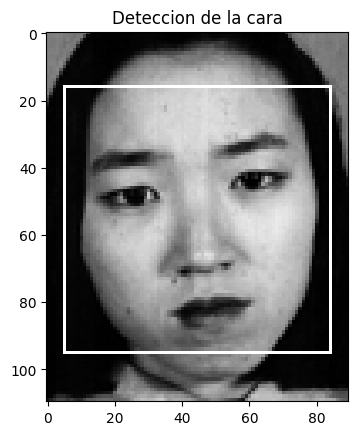

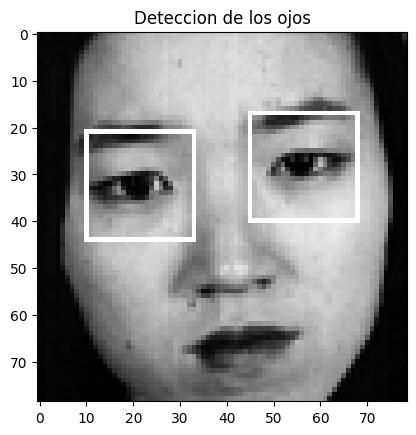

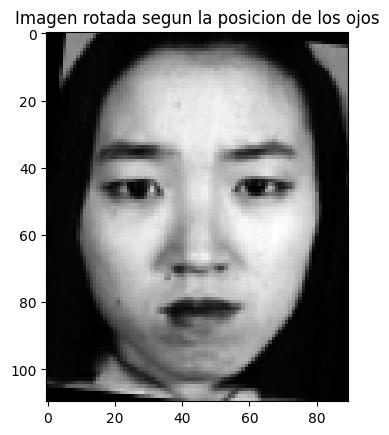

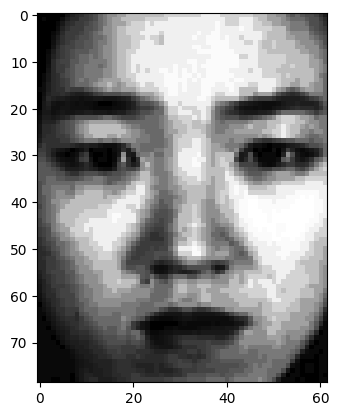

In [8]:
test_img = imageload(5,22)
pp_test_img = preprocess(test_img, show=True)
plt.imshow(pp_test_img, cmap='gray')
plt.show()

In [9]:
test_img.shape

(110, 90)

# 3. Feature Extraction


👉🏻 Utilizaremos Hog para la extraccion de caracteristicas, ya que queremos obtener caracteristicas de intensidad, lo que tendria buenos resultados para el caso de las expresiones faciales (arrugas, boca, nariz, entre otros)

In [11]:
K = 7 # Cantidad de clases del dataset
N = 30 # Cantidad de imagenes por clase
y = np.zeros((K * N), 'int') # Vector de clasificacion
# ------------------------------- Hog ------------------------------------------
hog_orientations = 9
px_0 = 16 # Parametro pixeles por bloque: 64 pixeles por bloque
cl_0 = 2 # Parametro celdas por bloque: 2 celdas por bloque
bn = 9 # Numero de bins del descriptor Hog.
Mhog = 720 # Numero de elementos en total del vector descriptor
Xhog = np.zeros((K * N, Mhog)) # Matriz  de caracteristicas para descriptor Hog

In [12]:
t = 0
Xhog = np.zeros((K * N, Mhog))
print(f' Extracting features ... '.center(100, '*'))
for k in range(K): # Por cada clase ...
    print(f'Extracting features: batch {k + 1}/7')
    for i in tqdm(range(N)): # Por cada imagen ...
        num_class = k + 1
        num_img = i + 1
        # Cargamos la i-esima imagen de la k-esima clase
        img = 255*imageload(num_class, num_img)
        # Preprocesamos la imagen para eliminar ruido y resaltar el lunar
        # Hog con 9 orientaciones
        Xhog[t,:] = hog(img, orientations=hog_orientations,
                            cells_per_block=(cl_0, cl_0),
                            pixels_per_cell=(px_0, px_0),
                            norm=False)
        # Vector de clasificacion
        y[t] = k + 1 # Deberia ser el mismo para los 3 canales.
        t = t + 1
print(" Features extracted successfully ".center(100, '*'))
X = Xhog
print(f'{X.shape}'.center(100))

************************************* Extracting features ... **************************************
Extracting features: batch 1/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 2/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 3/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 4/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 5/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 6/7


  0%|          | 0/30 [00:00<?, ?it/s]

Extracting features: batch 7/7


  0%|          | 0/30 [00:00<?, ?it/s]

**********************************Features extracted successfully***********************************
                                             (210, 720)                                             


👉🏻 Dado que en el metodo de estimacion Leave-one-out Person realizaremos todo dentro de la iteracion (tanto Split, Normalization, Clean y Features Selection/Transformation), en las siguientes secciones solo definiremos las funciones a utilizar segun sea el caso.  

# 4. Split Training, Testing y Validation sets

In [15]:
def split_train_test_val(X, y, i):
    """
    Input: Matriz de caracteristicas X y vector de clases y
    Output: Conjuntos training, testing y validation.
    """
    # i: i-esima mujer
    W = 10
    K = np.max(y) # Cantidad de clases = 7
    N = X.shape[0] // K # Numero de muestras por clase = 30
    N_test = (N // W) * K # numero de muestras de testing = 21
    N_val = (N // W) * K # numero de muestras de validation
    N_train = (N * K) - (N_test + N_val) # numero de muestras de training

    M = X.shape[1]  # Cantidad de caracteristicas

    # Matrices de caracteristicas para Training, testing y Validation.
    Xtrain = np.zeros((N_train, M))
    ytrain = np.zeros((N_train), 'int')

    Xtest = np.zeros((N_test, M))
    ytest = np.zeros((N_test), 'int')

    Xval = np.zeros((N_val, M))
    yval = np.zeros((N_val), 'int')


    t = 0
    itrain = 0
    itest = 0
    ival = 0

    test_start_idx = i * 3
    test_end_idx = test_start_idx + 2
    val_start_idx = ((i + 1) % W) * 3
    val_end_idx = val_start_idx + 2

    for k in range(0, K): # Por cada clase
        for n in range(0, N): # Por cada muestra
            # Testing -> Mujer i
            # Ejemplo: MujerTest = 0, entonces son las imagenes 0 hasta 2
            if test_start_idx <= n <= test_end_idx:
                Xtest[itest,:] = X[t,:]
                ytest[itest] = y[t]
                itest += 1
            # Validation -> Mujer i+1 % 10
            # Ejemplo: MujerVal = 1, entonces son las imagenes 3 hasta 5
            elif val_start_idx <= n <= val_end_idx:
                Xval[ival,:] = X[t,:]
                yval[ival] = y[t]
                ival +=1
            # Training -> Mujeres que no sean ni Mujer test o Mujer validation
            # Ejemplo: MujeresTrain = 2..9, entonces son las imagenes 6 hasta la 29
            else:
                Xtrain[itrain,:] = X[t,:]
                ytrain[itrain] = y[t]
                itrain += 1

            t += 1

    return Xtrain, ytrain, Xtest, ytest, Xval, yval


# 4. Clean and Normalization

In [16]:
def clean_and_normalize(Xtrain, Xtest, Xval):
  # aplicamos Clean para eliminar las columnas redundantes y evitar nulos
    sclean = clean(Xtrain)
    Xtrain_clean = Xtrain[:, sclean]
    Xtest_clean = Xtest[:, sclean]
    Xval_clean = Xval[:, sclean]
    # aplicamos normalizacion sobre training, y luego escalamos testing y validation.
    Xtrain_norm, a, b = minmax(Xtrain_clean)
    Xtest_norm = Xtest_clean * a + b
    Xval_norm = Xval_clean * a + b
    return Xtrain_norm, Xtest_norm, Xval_norm

# 5. Feature Selection and Transformation

In [515]:
class sfsbalu():
    def __init__(self, p, show=0):
        self.p = p
        self.show = show
    def fit(self,X,y):
        self.sel = sfs(X,y,self.p,show=self.show)
        self.m   = X.shape[1]
    def get_support(self):
        s = np.zeros((self.m,))
        s[self.sel] = 1
        return s
    def __repr__(self):
        return f"SFS = {self.sel}"

g = [
      sfsbalu(p=5),
      sfsbalu(p=20),
      #SelectFromModel(RandomForestClassifier(n_estimators=50), max_features=3),
      #SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=3),
      #SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=4),
      #SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=5),
      SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=6),
      SelectFromModel(LogisticRegression(penalty="l2"), max_features=6)
     ]

In [101]:


def sel_tran_features(Xtrain, ytrain, Xtest, Xval, option):
    """
    Funcion que selecciona las mejores caracteristicas y posteriormente retorna
    una matriz de caracteristicas con las columnas mas representativas.
    """
    if option == 0: # Opcion 0: sin seleccion ni transformacion
        return Xtrain, Xtest, Xval

    elif option == 1: # Opcion 2: SFS + PCA -- MAS ALTA HASTA EL MOMENTO
        # SFS - 15 columnas
        sel = sfs(Xtrain, ytrain, 15, show=True)  # obtenemos las mejores columnas de Xtrain
        Xtrain_sfs = Xtrain[:, sel]
        Xtest_sfs = Xtest[:, sel]
        Xval_sfs = Xval[:, sel]
        # PCA - 5 componentes
        Xtrain_pca, _, A, Xm, _ = pca(Xtrain_sfs, n_components=10)
        Xtest_pca               = np.matmul(Xtest_sfs - Xm, A)
        Xval_pca               = np.matmul(Xval_sfs - Xm, A)

        return Xtrain_pca, Xtest_pca, Xval_pca








# 6. Classification

👉🏻 En esta seccion utilizaremos el conjunto de modelos de clasifacion. Todos los guardaremos en un diccionario para probar el mejor modelo posteriormente en la evaluacion.

In [48]:
# --------------------------------- KNN ------------------------------------
n_neighbors = list(range(1, 30))
knns = [KNeighborsClassifier(n_neighbors = n) for n in n_neighbors]


# --------------------------------- SVM ------------------------------------
kernels = ["linear"]
gammas = [0.05, 0.1, 1, 10]
cs = [0.01, 0.1, 1, 10, 100]
degrees = [2, 5, 10, 15]
svms = []
for kernel in kernels:
  if kernel != 'linear':
    for c in cs:
      for gamma in gammas:
        if kernel == "poly":
          for degree in degrees:
            svms.append(SVC(kernel = kernel, C = c, gamma = gamma, degree = degree))
        else:
          svms.append(SVC(kernel = kernel, C = c, gamma = gamma))
  else:
    svms.append(SVC(kernel = kernel))


# ---------------------------- Random Forest --------------------------------
n_estimators = list(range(100, 300, 100))
depth = list(range(10, 30, 10))
random_forests = [RandomForestClassifier(n_estimators=n, max_depth=d) for d in depth for n in n_estimators]


# ---------------------------------- NN ------------------------------------
neuronal_networks = [
    MLPClassifier(hidden_layer_sizes=(75, 75), learning_rate_init=0.01, solver='sgd'),
    MLPClassifier(hidden_layer_sizes=(110 * 90), learning_rate_init=0.01, solver='sgd'), # largo x ancho de la imagen
    MLPClassifier(hidden_layer_sizes=(110 * 90 / 4), learning_rate_init=0.01, solver='sgd'), # largo x ancho / 4
    MLPClassifier(hidden_layer_sizes=(110 * 90, 110 * 90 / 4), learning_rate_init=0.01, solver='sgd'), # largo x ancho, largo x ancho / 4
]


In [49]:
# Diccionario de modelos h.
h = {
    'knn' : knns,
    'svm' : svms,
    'rfs' : random_forests,
    'NN'  : neuronal_networks,
}
h

{'knn': [KNeighborsClassifier(n_neighbors=1),
  KNeighborsClassifier(n_neighbors=2),
  KNeighborsClassifier(n_neighbors=3),
  KNeighborsClassifier(n_neighbors=4),
  KNeighborsClassifier(),
  KNeighborsClassifier(n_neighbors=6),
  KNeighborsClassifier(n_neighbors=7),
  KNeighborsClassifier(n_neighbors=8),
  KNeighborsClassifier(n_neighbors=9),
  KNeighborsClassifier(n_neighbors=10),
  KNeighborsClassifier(n_neighbors=11),
  KNeighborsClassifier(n_neighbors=12),
  KNeighborsClassifier(n_neighbors=13),
  KNeighborsClassifier(n_neighbors=14),
  KNeighborsClassifier(n_neighbors=15),
  KNeighborsClassifier(n_neighbors=16),
  KNeighborsClassifier(n_neighbors=17),
  KNeighborsClassifier(n_neighbors=18),
  KNeighborsClassifier(n_neighbors=19),
  KNeighborsClassifier(n_neighbors=20),
  KNeighborsClassifier(n_neighbors=21),
  KNeighborsClassifier(n_neighbors=22),
  KNeighborsClassifier(n_neighbors=23),
  KNeighborsClassifier(n_neighbors=24),
  KNeighborsClassifier(n_neighbors=25),
  KNeighborsCla

# 7. Evaluation (Leave One Out Person)

In [67]:
def holdout(clf, Xtrain, ytrain, Xtest, ytest):
    # Funcion de evaluacion
    clf.fit(Xtrain, ytrain)
    ypred  = clf.predict(Xtest)
    acc = accuracy_score(ytest, ypred)
    return acc


In [68]:
def find_best_model(h, clf_type, Xtrain, ytrain, Xval, yval):
    """
    Funcion que busca el mejor modelo utilizando el set de validacion.
    Retorna el mejor modelo encontrado segun el accuracy maximo.
    """
    q = len(h[clf_type]) # cantidad de clasificadores
    max_acc = 0 # maximo accuracy
    id_best_model = -1 # indice del mejor clasificador encontrado
    iteration = 0
    for k in range(0, q): # por cada clasificador
        clf = h[clf_type][k] # k-esimo Clasificador 'model'
        acc = holdout(clf, Xtrain, ytrain, Xval, yval) # obtenemos su accuracy
        if acc > max_acc:
            max_acc = acc
            id_best_model = k # mejor clasificador hasta el momento
            print(f'    - accVal: {round(max_acc, 4)} ***')
        else:
            print(f'    - accVal: {round(max_acc, 4)}')
            iteration += 1
    print(f'    => Best model finded = {h[clf_type][id_best_model]}')
    return id_best_model


In [102]:
def leave_one_out(clf_type, X, y):
    accuracies = []
    for i in range(0, 10):
        print(f'Validation - Testing Woman ({i + 1})')
        # 1. Realizamos Split sets training, testing y de validacion
        Xtrain, ytrain, Xtest, ytest, Xval, yval = split_train_test_val(X, y, i)

        # 2. Aplicamos Clean y Normalizacion
        Xtrain_norm, Xtest_norm, Xval_norm = clean_and_normalize(Xtrain, Xtest, Xval)

        # 3. Aplicamos seleccion y transformacion de caracteristicas
        Xtrain_sel, Xtest_sel, Xval_sel = sel_tran_features(Xtrain_norm, ytrain, Xtest_norm, Xval_norm, 1)

        # 4. Select best model: Buscamos el mejor modelo utilizando el set de validacion
        #id_best_model = find_best_model(h, clf_type, Xtrain_norm, ytrain, Xval_norm, yval)
        id_best_model = find_best_model(h, clf_type, Xtrain_sel, ytrain, Xval_sel, yval)

        # 5. Aplicamos el mejor clasificador en testing y obtenemos el accuracy
        best_h = h[clf_type][id_best_model]
        #accuracy = holdout(best_h, Xtrain_norm, ytrain, Xtest_norm, ytest)

        accuracy = holdout(best_h, Xtrain_sel, ytrain, Xtest_sel, ytest)
        print(f'  - accTest: ', accuracy)
        print("-" * 100)
        accuracies.append(accuracy)

    acc = np.mean(accuracies)
    std = np.std(accuracies)
    acc_st = "{:.2f} +/- {:.2f}".format(acc*100,std*100)
    print(f'Accuracy (LOUP) = {acc_st}')

leave_one_out('knn', X, y)



Validation - Testing Woman (1)


Selecting Features: 100%|██████████| 15.0/15.0 [00:14<00:00, 1.00 features/s]


    - accVal: 0.3333 ***
    - accVal: 0.381 ***
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.4762 ***
    - accVal: 0.4762
    - accVal: 0.4762
    - accVal: 0.4762
    - accVal: 0.4762
    - accVal: 0.4762
    - accVal: 0.4762
    - accVal: 0.4762
    - accVal: 0.4762
    - accVal: 0.5238 ***
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    => Best model finded = KNeighborsClassifier(n_neighbors=16)
  - accTest:  0.7619047619047619
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (2)


Selecting Features: 100%|██████████| 15.0/15.0 [00:14<00:00, 1.02 features/s]


    - accVal: 0.4286 ***
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.5238 ***
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5714 ***
    - accVal: 0.619 ***
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    => Best model finded = KNeighborsClassifier(n_neighbors=21)
  - accTest:  0.7142857142857143
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (3)


Selecting Features: 100%|██████████| 15.0/15.0 [00:17<00:00, 1.16s/ features]


    - accVal: 0.4762 ***
    - accVal: 0.4762
    - accVal: 0.4762
    - accVal: 0.4762
    - accVal: 0.4762
    - accVal: 0.4762
    - accVal: 0.4762
    - accVal: 0.4762
    - accVal: 0.4762
    - accVal: 0.6667 ***
    - accVal: 0.7143 ***
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    => Best model finded = KNeighborsClassifier(n_neighbors=11)
  - accTest:  0.6666666666666666
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (4)


Selecting Features: 100%|██████████| 15.0/15.0 [00:14<00:00, 1.01 features/s]


    - accVal: 0.5238 ***
    - accVal: 0.619 ***
    - accVal: 0.6667 ***
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.6667
    => Best model finded = KNeighborsClassifier(n_neighbors=3)
  - accTest:  0.5714285714285714
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (5)


Selecting Features: 100%|██████████| 15.0/15.0 [00:14<00:00, 1.02 features/s]


    - accVal: 0.3333 ***
    - accVal: 0.3333
    - accVal: 0.3333
    - accVal: 0.4286 ***
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.4286
    => Best model finded = KNeighborsClassifier(n_neighbors=4)
  - accTest:  0.6190476190476191
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (6)


Selecting Features: 100%|██████████| 15.0/15.0 [00:14<00:00, 1.03 features/s]


    - accVal: 0.3333 ***
    - accVal: 0.3333
    - accVal: 0.3333
    - accVal: 0.3333
    - accVal: 0.3333
    - accVal: 0.3333
    - accVal: 0.3333
    - accVal: 0.381 ***
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    => Best model finded = KNeighborsClassifier(n_neighbors=8)
  - accTest:  0.5238095238095238
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (7)


Selecting Features: 100%|██████████| 15.0/15.0 [00:15<00:00, 1.01s/ features]


    - accVal: 0.5238 ***
    - accVal: 0.5238
    - accVal: 0.5714 ***
    - accVal: 0.619 ***
    - accVal: 0.6667 ***
    - accVal: 0.6667
    - accVal: 0.7619 ***
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    - accVal: 0.7619
    => Best model finded = KNeighborsClassifier(n_neighbors=7)
  - accTest:  0.3333333333333333
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (8)


Selecting Features: 100%|██████████| 15.0/15.0 [00:14<00:00, 1.01 features/s]


    - accVal: 0.381 ***
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    - accVal: 0.381
    => Best model finded = KNeighborsClassifier(n_neighbors=1)
  - accTest:  0.42857142857142855
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (9)


Selecting Features: 100%|██████████| 15.0/15.0 [00:14<00:00, 1.02 features/s]


    - accVal: 0.5238 ***
    - accVal: 0.5714 ***
    - accVal: 0.619 ***
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.6667 ***
    - accVal: 0.6667
    - accVal: 0.6667
    - accVal: 0.7143 ***
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    - accVal: 0.7143
    => Best model finded = KNeighborsClassifier(n_neighbors=14)
  - accTest:  0.19047619047619047
----------------------------------------------------------------------------------------------------
Validation - Testing Woman (10)


Selecting Features: 100%|██████████| 15.0/15.0 [00:14<00:00, 1.01 features/s]

    - accVal: 0.4286 ***
    - accVal: 0.4286
    - accVal: 0.4286
    - accVal: 0.5238 ***
    - accVal: 0.5238
    - accVal: 0.5238
    - accVal: 0.5714 ***
    - accVal: 0.5714
    - accVal: 0.5714
    - accVal: 0.619 ***
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    - accVal: 0.619
    => Best model finded = KNeighborsClassifier(n_neighbors=10)
  - accTest:  0.8571428571428571
----------------------------------------------------------------------------------------------------
Accuracy (LOUP) = 56.67 +/- 19.34
